In [1]:
from astropy.convolution import convolve_fft
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image

psf_path = "/home/matteo/MIRAGE/Simulazioni/simulazioni/kernels/kernel_irac1.fits"
psf = fits.getdata(psf_path)

def psf_convolve(x):
    return convolve_fft(x, psf)

def generate_modulated_noise(shape, slope=0.1, intercept=1.0, mean=0.0, std=1.0):
    """
    Genera un rumore gaussiano modulato da una funzione lineare.

    Parameters:
        shape (tuple): Dimensione del rumore (es. (height, width)).
        slope (float): Pendenza della funzione lineare.
        intercept (float): Intercetta della funzione lineare.
        mean (float): Media del rumore gaussiano.
        std (float): Deviazione standard del rumore gaussiano.

    Returns:
        np.ndarray: Matrice 2D di rumore modulato.
    """
    # Creazione della griglia 2D
    x = np.linspace(0, 1, shape[1])
    y = np.linspace(0, 1, shape[0])
    x_grid, y_grid = np.meshgrid(x, y)

    # Calcolo della funzione lineare (modulazione)
    modulation = slope * x_grid + intercept

    # Generazione del rumore gaussiano
    gaussian_noise = np.random.normal(mean, std, shape)

    # Modulazione del rumore
    modulated_noise = gaussian_noise * modulation

    return modulated_noise


def sersic_profile_2d(x, y, I_e, R_e, n, x0, y0, q):
    """
    Calcola il profilo di Sérsic 2D su una griglia.

    Parameters:
        x, y (np.ndarray): Coordinate della griglia 2D.
        I_e (float): Luminosità efficace.
        R_e (float): Raggio efficace.
        n (float): Indice di Sérsic.
        x0, y0 (float): Coordinate del centro.
        q (float): Rapporto assiale (b/a).

    Returns:
        np.ndarray: Luminosità sulla griglia 2D.
    """
    # Calcola la distanza radiale r sulla griglia
    r = np.sqrt(((x - x0) ** 2) / q + q * (y - y0) ** 2)

    # Calcola b_n
    b_n = (
        2 * n - 1 / 3 if n > 0.36 else 1.9992 * n - 0.3271
    )  # Approssimazione per bassi n

    # Formula del profilo di Sérsic
    return I_e * np.exp(-b_n * ((r / R_e) ** (1 / n) - 1))

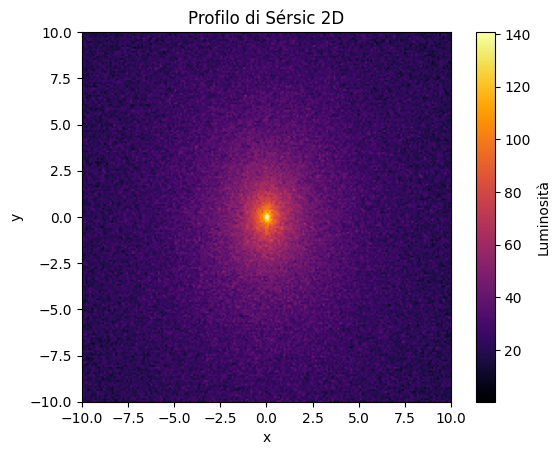

In [2]:



# Creazione di una griglia 2D
x = np.linspace(-10, 10, 200)  # Intervallo sull'asse x
y = np.linspace(-10, 10, 200)  # Intervallo sull'asse y
x_grid, y_grid = np.meshgrid(x, y)

# Parametri del profilo di Sérsic
I_e = 2.5  # Luminosità efficace
R_e = 20.0  # Raggio efficace
n = 2.3  # Indice di Sérsic
x0, y0 = 0, 0  # Centro
q = 0.7  # Rapporto assiale (ellitticità)

# Calcolo della luminosità 2D
I_2d = sersic_profile_2d(x_grid, y_grid, I_e, R_e, n, x0, y0, q)

# noise
#modulated_noise = generate_modulated_noise(np.shape(I_2d), 0, 0, 102, 10)
noise = make_noise_image(
    shape=np.shape(I_2d),  # Ks_bkg_data.shape,
    mean=15,
    stddev=5,
)
I_2d += noise
# Visualizzazione del profilo

#convolved 
#I_2d = convolve_fft(I_2d, psf)


plt.imshow(I_2d, origin="lower", extent=(-10, 10, -10, 10), cmap="inferno")
plt.colorbar(label="Luminosità")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Profilo di Sérsic 2D")
plt.show()



MODEL NAME: SimpleModel
FREE PARAMS: 6
GRID VARIABLES: ['x', 'y']
N-DIM: 2
----------------------------------------------------------------------------------------------------
  INDEX  NAME      VALUE  IS-FREE    PRIOR               DESCR
      0  I_e         1.5  Yes        Uniform(-inf, inf)
      1  R_e        24    Yes        Uniform(-inf, inf)
      2  n           2.4  Yes        Uniform(-inf, inf)
      3  x0          0    Yes        Uniform(-inf, inf)
      4  y0          0    Yes        Uniform(-inf, inf)
      5  q           0.5  Yes        Uniform(-inf, inf)


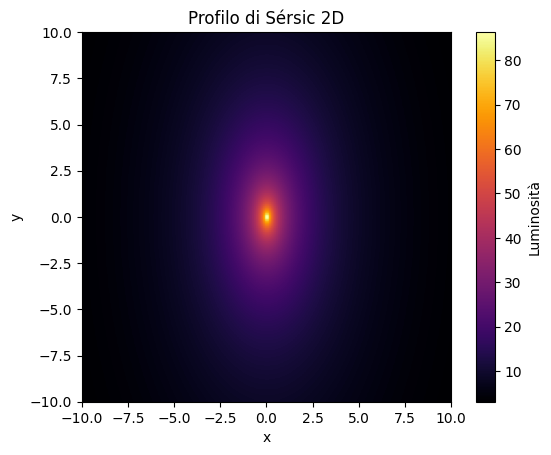

In [3]:
from model import Model
from fitting import MCMC

sersic = Model.wrap(sersic_profile_2d, grid_variables=['x', 'y'], initial_values={
    'I_e':I_e-1,
    'R_e':R_e+4,
    'q':q-.2,
    'x0':x0,
    'y0':y0,
    'n':n+.1
})

psf_model = Model.wrap(psf_convolve, grid_variables=['x'])

source_model = sersic #| psf_model
print(source_model)
plt.imshow(sersic(x_grid, y_grid), origin="lower", extent=(-10, 10, -10, 10), cmap="inferno")
#plt.imshow(source_model(x_grid,y_grid,I_e_0 = 2.0 ,R_e_0 = 9.0,n_0 = 3.5,x0_0=0, y0_0 = 0,q_0 = 0.7), origin="lower", extent=(-10, 10, -10, 10), cmap="inferno")
plt.colorbar(label="Luminosità")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Profilo di Sérsic 2D")
plt.show()


In [5]:
sersic.freeze_parameters(x0=0, y0=0)
fitter = MCMC(sersic)
results = fitter.fit(
    x = x_grid,
    y = y_grid,
    data = I_2d,
    optimize=True,
    nwalkers=30,
    nsteps=2000,
    burn_in=500,
    dispersion=0.1,
    theta0=[p.value for p in source_model.free_parameters],
    error=noise/5
)

print(results)

Optimization done, initial position is [ 2.20859708 23.13651537  2.46949466  0.63861576]


100%|██████████| 2000/2000 [00:28<00:00, 69.05it/s]

=== MCMCResult ===
    success   = True
    message   = MCMC sampling completed successfully
    discard   = 0
    thin      = 1
    ndata     = 200
    nvarys    = 4
    chisqr    = 8.822e+06
    redchi    = 4.501e+04
    aic       = 2147
    bic       = 2160
    best_fit:
  I_e = 2.209  
  R_e = 23.14  
  n = 2.469  
  q = 0.6386  

    Parameter summary (median [p16, p84]):
        I_e            : 2.209 [2.192, 2.225]
        R_e            : 23.14 [23.01, 23.26]
        n              : 2.469 [2.463, 2.476]
        q              : 0.6386 [0.6382, 0.6391]


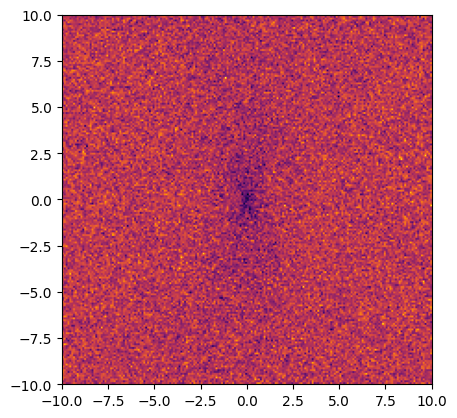

In [6]:
plt.imshow(
    I_2d-sersic(
        x_grid, y_grid, **results.best_fit_dict
    ),
    origin="lower",
    extent=(-10, 10, -10, 10),
    cmap="inferno",
)
